In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/shipment price prediction/train.csv')
df.head()

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost
0,fffe3900350033003300,Billy Jenkins,0.26,17.0,6.0,4128.0,Brass,13.91,16.27,Yes,Yes,No,Airways,No,Working Class,No,06/07/15,06/03/15,"New Michelle, OH 50777",-283.29
1,fffe3800330031003900,Jean Bryant,0.28,3.0,3.0,61.0,Brass,6.83,15.00,No,No,No,Roadways,No,Working Class,No,03/06/17,03/05/17,"New Michaelport, WY 12072",-159.96
2,fffe3600370035003100,Laura Miller,0.07,8.0,5.0,237.0,Clay,4.96,21.18,No,No,No,Roadways,Yes,Working Class,Yes,03/09/15,03/08/15,"Bowmanshire, WA 19241",-154.29
3,fffe350031003300,Robert Chaires,0.12,9.0,NaN,NaN,Aluminium,5.81,16.31,No,No,No,NaN,No,Wealthy,Yes,05/24/15,05/20/15,"East Robyn, KY 86375",-161.16
4,fffe3900320038003400,Rosalyn Krol,0.15,17.0,6.0,324.0,Aluminium,3.18,11.94,Yes,Yes,Yes,Airways,No,Working Class,No,12/18/16,12/14/16,"Aprilside, PA 52793",-159.23


# DATA CLEANING

## Check Null Values

In [4]:
features_with_na=[features for features in df.columns if df[features].isnull().sum()>=1]
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean()*100,5), '% missing values')

Artist Reputation 11.53846 % missing values
Height 5.76923 % missing values
Width 8.98462 % missing values
Weight 9.03077 % missing values
Material 11.75385 % missing values
Transport 21.41538 % missing values
Remote Location 11.86154 % missing values


#### Checking duplicated values

In [5]:
df.duplicated().sum()

0

#### Seperating Features

In [6]:
target_feature = 'Cost'

# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
numeric_features.remove(target_feature)
non_numeric_features = [feature for feature in df.columns if df[feature].dtype == 'O']

print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} Non Numeric features : {}'.format(len(non_numeric_features), non_numeric_features))

We have 6 numerical features : ['Artist Reputation', 'Height', 'Width', 'Weight', 'Price Of Sculpture', 'Base Shipping Price']

We have 13 Non Numeric features : ['Customer Id', 'Artist Name', 'Material', 'International', 'Express Shipment', 'Installation Included', 'Transport', 'Fragile', 'Customer Information', 'Remote Location', 'Scheduled Date', 'Delivery Date', 'Customer Location']


#### Imputing null values with median to check the multicollinearity

In [7]:
df1 = df.copy()
for i in numeric_features:
    df1[i].fillna(df1[i].median(), inplace=True)

#### Data Distribution

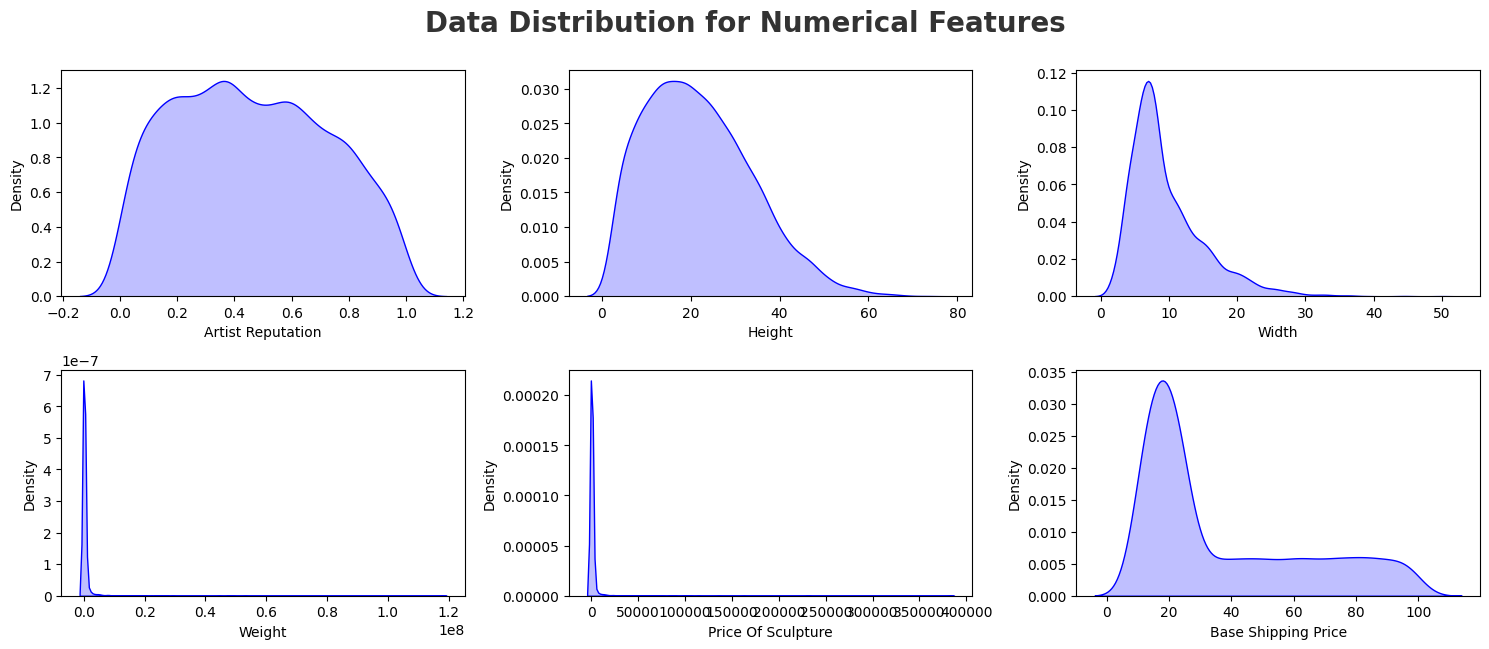

In [8]:
plt.figure(figsize=(15, 15))
plt.suptitle('Data Distribution for Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(numeric_features)):
    plt.subplot(5, 3, i+1)
    sns.kdeplot(x=df[numeric_features[i]],shade=True, color='b')
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

#### Skewness

In [9]:
df[numeric_features].skew()

,0
Artist Reputation,0.141363
Height,0.594041
Width,1.546702
Weight,21.556174
Price Of Sculpture,22.206823
Base Shipping Price,0.918102


#### Checking the power transformer on outlier columns

In [10]:
outlier_feature = ['Price Of Sculpture', 'Weight']

In [11]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(standardize=False)

outlier_data = df1[outlier_feature]

In [12]:
df1[outlier_feature] = pt.fit_transform(df1[outlier_feature])

In [13]:
df_outlier = pd.DataFrame(outlier_data, columns=outlier_feature)

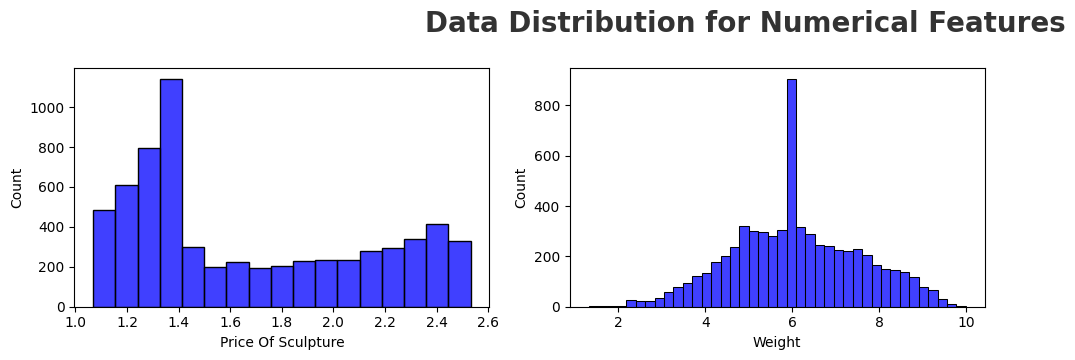

In [14]:
plt.figure(figsize=(15, 15))
plt.suptitle('Data Distribution for Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(outlier_feature)):
    plt.subplot(5, 3, i+1)
    sns.histplot(x=df1[outlier_feature[i]], color='b')
    plt.xlabel(outlier_feature[i])
    plt.tight_layout()

In [15]:
df1[outlier_feature].skew()

,0
Price Of Sculpture,0.478648
Weight,0.027309


#### Removing outliers from Target Column

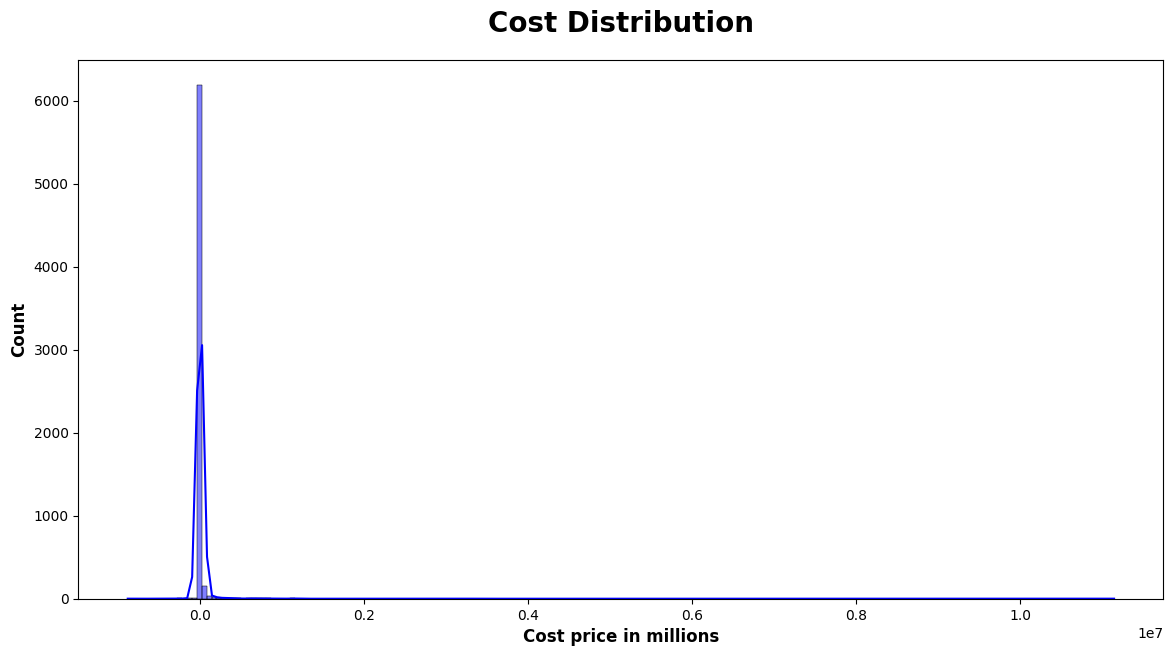

In [16]:
plt.subplots(figsize=(14,7))
sns.histplot(df['Cost'], bins=200, kde=True, color = 'b')
plt.title("Cost Distribution", weight="bold",fontsize=20, pad=20)
plt.ylabel("Count", weight="bold", fontsize=12)
plt.xlabel("Cost price in millions", weight="bold", fontsize=12)
plt.show()

Log Transformation for normalization

In [17]:
df1['Cost'] = np.log1p(df1['Cost'])

(array([1973., 1985.,  954.,  461.,  223.,  127.,   64.,   32.,   16.,
           6.]),
 array([ 4.46671239,  5.64267721,  6.81864203,  7.99460685,  9.17057167,
        10.34653649, 11.5225013 , 12.69846612, 13.87443094, 15.05039576,
        16.22636058]),
 <BarContainer object of 10 artists>)

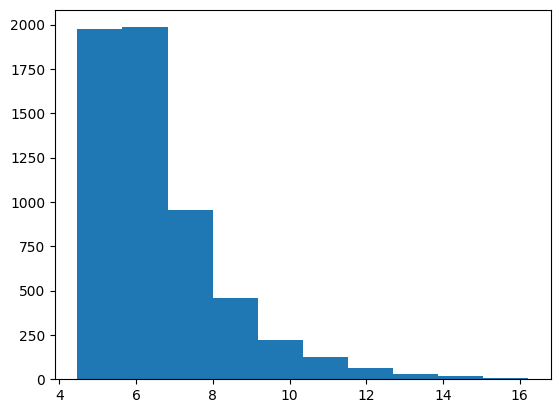

In [18]:
plt.hist(df1['Cost'])

Feature Creation

In [19]:
# Convert object datatype to datetime
df['Scheduled Date'] = pd.to_datetime(df['Scheduled Date'])
df['Delivery Date'] = pd.to_datetime(df['Delivery Date'])

In [20]:
df['Month'] = pd.to_datetime(df['Scheduled Date']).dt.month
df['Year'] = pd.to_datetime(df['Scheduled Date']).dt.year

numeric_features.append('Month')
numeric_features.append('Year')

Drop Unnecessary Column


Drop `Customer Id`, `Artist Name` and `Customer Location` columns having huge number of unique values.

`Scheduled Date` and `Delivery Date` can be dropped since the required features are extracted form it

In [21]:
to_drop_columns = ['Customer Id', 'Artist Name', 'Customer Location', 'Scheduled Date', 'Delivery Date']

In [22]:
df.drop(columns=to_drop_columns, inplace=True)

Model Building

In [23]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV


Split X AND Y

In [24]:
X = df.drop(columns = ['Cost'], axis=1)
y = np.abs(df['Cost'])

In [25]:
y = np.log1p(y)

####TRAIN TEST SPLIT

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

####FEATURE ENCODING AND SCALING


In [27]:
numeric_features = [x for x in numeric_features if x not in outlier_feature]
categorical_features = [x for x in non_numeric_features if x not in to_drop_columns]

(numeric_features), (categorical_features), (outlier_feature)

(['Artist Reputation',
  'Height',
  'Width',
  'Base Shipping Price',
  'Month',
  'Year'],
 ['Material',
  'International',
  'Express Shipment',
  'Installation Included',
  'Transport',
  'Fragile',
  'Customer Information',
  'Remote Location'],
 ['Price Of Sculpture', 'Weight'])

In [28]:
numeric_features_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

categorical_features_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder()),
]
)

outliers_features_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('transformer', PowerTransformer(standardize=True))
])

preprocessor = ColumnTransformer(
    [
        ("Numeric Pipeline",numeric_features_pipeline, numeric_features),
        ("Categorical Features Pipeline",categorical_features_pipeline, categorical_features),
        ("Outliers Features Pipeline", outliers_features_pipeline, outlier_feature)
]
)

In [29]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## Model Selection
* **Here should understand the Various Classification models with default values from these models we can choose top 4 with Highest Accuracy score and proceed with HyperParameter Tuning**


####CALCULATE PARAMETERS

In [30]:
# functions which takes true and predicted values to calculate metrics
def evaluate_reg(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [31]:
# function which can evaluate models and return a report
def evaluate_models(X_train, X_test, y_train, y_test, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    models_list = []
    r2_list = []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Evaluate Train and Test dataset
        model_train_mae , model_train_rmse, model_train_r2 = evaluate_reg(y_train, y_train_pred)

        model_test_mae , model_test_rmse, model_test_r2 = evaluate_reg(y_test, y_test_pred)


        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
        print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
        print("- R2 Score: {:.4f}".format(model_train_r2))

        print('----------------------------------')

        print('Model performance for Test set')
        print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
        print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
        print("- R2 Score: {:.4f}".format(model_test_r2))
        r2_list.append(model_test_r2)

        print('='*35)
        print('\n')

    report=pd.DataFrame(list(zip(models_list, r2_list)), columns=['Model Name', 'r2_score']).sort_values(by=['r2_score'], ascending=False)

    return report

In [ ]:
# Initialize models required for model
models = {
    "Linear Regression": LinearRegression(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),

}

In [33]:
base_report = evaluate_models(X_train, X_test, y_train, y_test, models)

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 0.7357
- Mean Absolute Error: 0.4971
- R2 Score: 0.8014
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.6966
- Mean Absolute Error: 0.4841
- R2 Score: 0.8218


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 0.5675
- Mean Absolute Error: 0.3614
- R2 Score: 0.8818
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.6588
- Mean Absolute Error: 0.4263
- R2 Score: 0.8406


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.5219
- Mean Absolute Error: 0.3275
- R2 Score: 0.8999


Random Forest Regressor
Model performance for Training set
- Root Mean Squared Error: 0.1229
- Mean Absolute Error: 0.0788
- R2 Score: 0.99

In [34]:
base_report

,Model Name,r2_score
3,Random Forest Regressor,0.955725
2,Decision Tree,0.899938
1,K-Neighbors Regressor,0.840555
0,Linear Regression,0.821773


# **BEST MODEL IS RANDOM FOREST REGRESSOR WITH R2_SCORE 96.0013 %**